In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from scipy.stats import multivariate_normal
from scipy.stats import lognorm
from sklearn.linear_model import LinearRegression
import pandas as pd


figsize = (15,8)
#sns.set_style("whitegrid")
#sns.set_palette("colorblind")
#palette = sns.color_palette()
#figsize = (15,8)
#legend_fontsize = 16

# from matplotlib import rc
# rc('font',**{'family':'sans-serif'})
# # rc('text', usetex=True)
# # rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# # rc('text.latex',preamble=r'\usepackage[russian]{babel}')
# rc('figure', **{'dpi': 300})

Шальнов Павел DS21

# 1.1,2

Пусть событие G - невиновен, событие I - кровь убийцы и подсудимого совпала.
В задаче прокурор должен был оценить вероятность, что подсудимый виновен, если редкая кровь подсудимого совпала с редкой кровью убийцы, то есть формула будет выглядить так:
$ P(G|I) = \frac{P(I|G) * P(G)}{P(I)}$


Прокурор: "Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен - всего 1%"
То есть прокурор оценил $ P(I|G) = \frac{P(G|I) * P(I)}{P(G)} $

P(G|I) - вероятность того, что обвиняемый невиновен, несмотря на доказательства I (совпадения крови).
P(I|G) - вероятность того, что совпадение крови будет выполнено, даже если обвиняемый невиновен.

P(G) - вероятность невиновности независимо от результатов теста крови.
P(I) - это априорная вероятность того, что крови совпадут (независимо от невиновности).

$ P(G|I) = \frac{P(I|G) * P(G)}{P(I)}$
Это уравнение показывает, что небольшой P(I|G) не подразумевает небольшой P(G|I) в случае большого P(G) и небольшой P(I)
То есть, если в противном случае обвиняемый может оказаться невиновным и вряд ли кто-либо еще представит улики в виде совпадения крови.То есть в общем случае соотносить вероятности P(G|I) и P(I|G) не верно.( это будет зависить от численности населения)


Адвокат оценил: 
$ P(\bar{G}|I) = \frac{P(I|\bar{G}) * P(\bar{G})}{P(I)}$
В расчетах адвоката не учитывалась априорная вероятность виновности подсудимого $P(\bar{G})$

# 1.3

In [25]:
def compute_posterior(data, prior_prob=0.01, test_success=0.95, spec=0.95):
    if data == 1:
        return prior_prob * test_success / (prior_prob * test_success + (1 - spec) * (1 - prior_prob))
    elif data == 0:
        return prior_prob * (1 - test_success) / (prior_prob * (1 - test_success) + spec * (1 - prior_prob))  
  

In [26]:
print("Апостериорная вероятность после положительного теста: %.6f" % compute_posterior(1) )
print("Апостериорная вероятность после отрицательного теста: %.6f" % compute_posterior(0) )

Апостериорная вероятность после положительного теста: 0.161017
Апостериорная вероятность после отрицательного теста: 0.000531


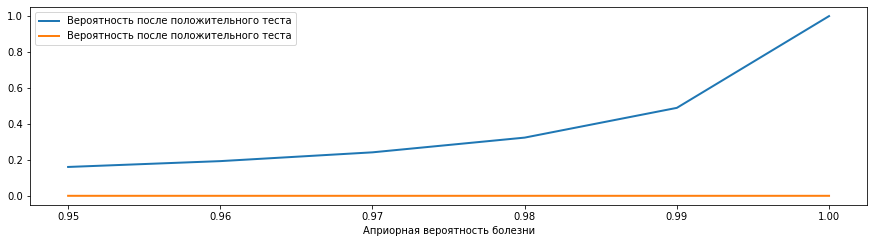

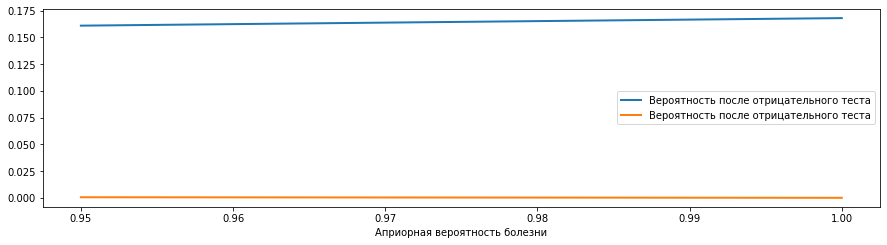

In [28]:
vector_posterior_spec = np.vectorize(compute_posterior, excluded=['data', 'test_success'])
vector_posterior_success = np.vectorize(compute_posterior, excluded=['data', 'spec'])
xs = np.arange(0.95, 1., 0.01)

ys_one_spec = vector_posterior_spec(1, spec=xs)
ys_zero_spec = vector_posterior_spec(0, spec=xs)
ys_one_success = vector_posterior_success(1, test_success=xs)
ys_zero_success = vector_posterior_success(0, test_success=xs)


fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(211)
ax1.plot(xs, ys_one_spec, linewidth=2, label=r'Вероятность после положительного теста')
ax1.plot(xs, ys_zero_spec, linewidth=2, label=r'Вероятность после положительного теста')
ax1.set_xlabel('Априорная вероятность болезни')
plt.legend()
plt.show()


fig = plt.figure(figsize=figsize)
ax2 = fig.add_subplot(212)
ax2.plot(xs, ys_one_success, linewidth=2, label='Вероятность после отрицательного теста')
ax2.plot(xs, ys_zero_success, linewidth=2, label='Вероятность после отрицательного теста')
ax2.set_xlabel('Априорная вероятность болезни')
plt.legend()
plt.show()

Вывод: Уменьшая ложно-положительную ошибку, апостериорная вероятность болезни при положительном тесте стремится к 1. При уменьшении ложно-отрицательной ошибки результаты намного скромнее, поэтому медикам стоит сосредоточиться на том чтобы уменьшать ложно-положительную ошибку.

# 2

In [9]:
data = pd.read_csv('/Users/pavel/Downloads/owid-covid-data.csv', parse_dates=['date'])

In [10]:
data.loc[data['new_cases'] == 0, 'new_cases'] = 1

In [11]:
data_russia = data[data['location'] == 'Russia']

In [12]:
data_russia_may = data_russia[data_russia['date'] >= '2020-03-03']

In [14]:
data_russia_may['day'] = np.arange(len(data_russia_may))
data_russia_may['days_squared'] = data_russia_may['day'] ** 2

/Users/pavel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/pavel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
train, test = data_russia_may[:50], data_russia_may[50:]

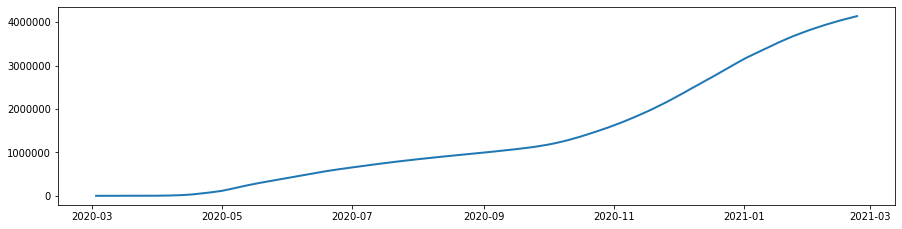

In [32]:
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(211)
ax1.plot(data_russia_may.date.values, data_russia_may.total_cases.values, linewidth=2, label='Количество заболевших')
plt.show()


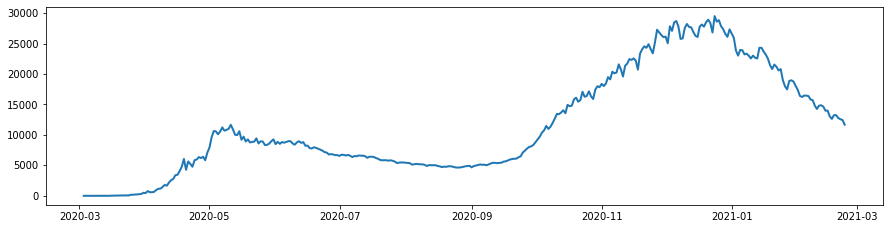

In [33]:
fig = plt.figure(figsize=figsize)
ax2 = fig.add_subplot(212)
ax2.plot(data_russia_may.date.values, data_russia_may.new_cases.values, linewidth=2, label='Прирост заболевших')
plt.show()

# 2a

In [37]:
linereg = LinearRegression()
linereg.fit(train.day.values.reshape(-1, 1), np.log(train.total_cases.values))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

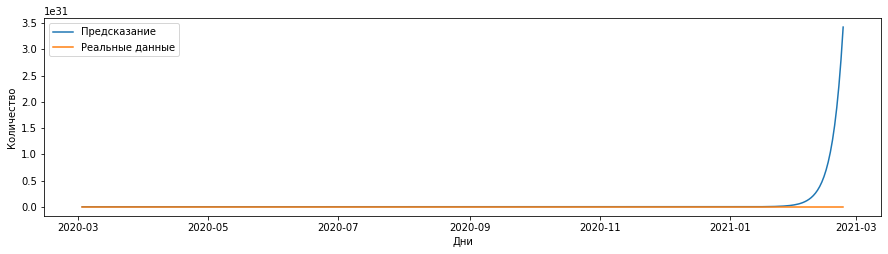

In [52]:
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(211)
ax1.plot(data_russia_may.date, np.exp(linereg.predict(data_russia_may.day.values.reshape(-1, 1))), label='Предсказание')
ax1.plot(data_russia_may.date, data_russia_may.total_cases.values, label='Реальные данные')
ax1.set_xlabel('Дни')
ax1.set_ylabel('Количество')
ax1.legend()
plt.show()

# 2b

In [65]:
pred = linereg.predict(train.day.values.reshape(-1, 1))
sigma_ = np.sqrt(np.sum((pred - np.log(train.total_cases.values)) ** 2) / len(train))

In [86]:
N = 250
X = np.linspace(-1, 1, N)
Y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def myplot_heatmap(Z, title, xlim=(-1, 1), ylim=(-1, 1), point=None):
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.title(title)
    if point is not None:
        plt.scatter(point[0], point[1], marker='*', s=120, c='b')

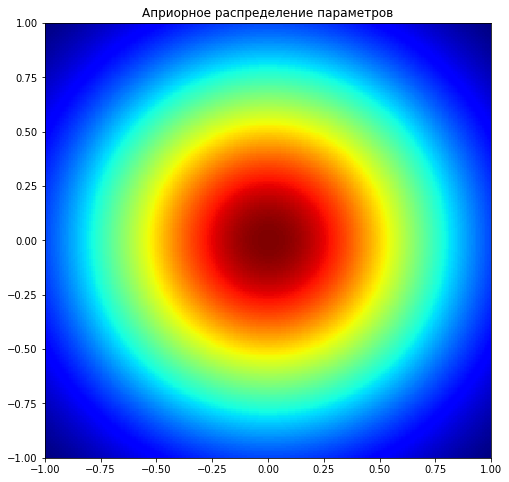

In [87]:
mu_ = np.array([0, 0])
cur_sigma_ = np.array([[1000, 0], [0, 1000]])

Z = multivariate_normal.pdf(pos, mean=mu_, cov=sigma_)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))
myplot_heatmap(Z, title='Априорное распределение параметров')

In [88]:
def bayesian_update(mu, sigma, x, y, sigma_noise=sigma_):
    x_matrix = np.array([[1., x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

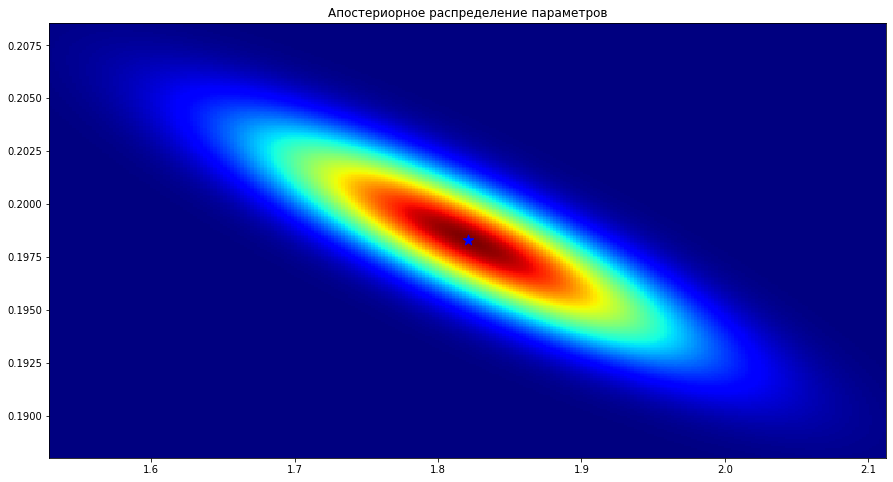

In [89]:
x_val, y_val = train.day.values, np.log(train.total_cases.values)

for i in range(len(train)):
    mu_, cur_sigma_ = bayesian_update(mu_, cur_sigma_, x_val[i], y_val[i])
    

s0, s1 = 3 * np.sqrt(cur_sigma_.diagonal())
X = np.linspace(mu_[0] - s0, mu_[0] + s0, N)
Y = np.linspace(mu_[1] - s1, mu_[1] + s1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean=mu_, cov=cur_sigma_)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
# ax.set_xlim((cur_mu[0] - s0, cur_mu[0] + s0))
# ax.set_ylim((cur_mu[1] - s1, cur_mu[1] + s1))
myplot_heatmap(Z, title='Апостериорное распределение параметров', xlim=(mu_[0] - s0, mu_[0] + s0), 
             ylim=(mu_[1] - s1, mu_[1] + s1), point=(linereg.intercept_, linereg.coef_[0]))

In [97]:
print('Параметры линейной регрессии: (%.4f, %.4f)' % (linereg.intercept_, linereg.coef_[0]))
print('Центр апостериорного распределения параметров: (%.4f, %.4f)' % (mu_[0], mu_[1]))

Параметры линейной регрессии: (1.8207, 0.1983)
Центр апостериорного распределения параметров: (1.8207, 0.1983)


# 2c

In [101]:
may = data_russia_may[data_russia_may.date == '2020-05-01'].day.values[0]
june = data_russia_may[data_russia_may.date == '2020-06-01'].day.values[0]
september = data_russia_may[data_russia_may.date == '2020-09-01'].day.values[0]

In [103]:
def myplot_sample_lines(days, may, june, september, mu, sigma, xs, n=20):
    may_list = []
    june_list = [] 
    september_list = []
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    
    for i, w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
        plt.plot(days, np.exp(w[0] + w[1]*days), 'k-', lw=.4)
        may_list.append(np.exp(w[0] + w[1]*days)[may])
        june_list.append(np.exp(w[0] + w[1]*days)[june])
        september_list.append(np.exp(w[0] + w[1]*days)[september])
        plt.xlabel('Дни')
        plt.ylabel('Количество заболевших')
    
    print(f'Количество заболевших к 1 мая: {int(np.mean(may_list))}')
    print(f'Количество заболевших к 1 июня: {int(np.mean(june_list))}')
    print(f'Количество заболевших к 1 сентября: {int(np.mean(september_list))}')
                           
    return res

Количество заболевших к 1 мая: 751528
Количество заболевших к 1 июня: 357765162
Количество заболевших к 1 сентября: 33957312711704936


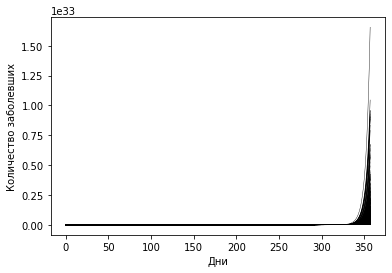

In [104]:
x = myplot_sample_lines(data_russia_may.day.values, may, june, september, 
                        mu_, cur_sigma_, np.arange(200), n=1500)

In [119]:
predict_mu = lambda x: mu_[0] + mu_[1] * x
predict_sigma = lambda x: np.sqrt(sigma_ ** 2 + (np.array([[1., x]]).dot(cur_sigma_)).dot(np.transpose(np.array([[1., x]])))[0][0]) 
                               

/Users/pavel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/pavel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


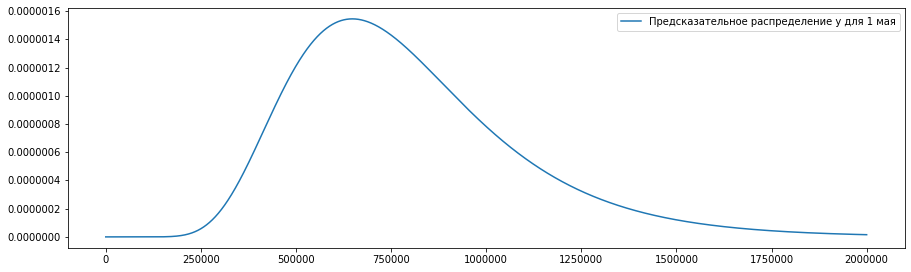

In [126]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(311)
lgn1 = lognorm(s=predict_sigma(may), scale=np.exp(predict_mu(may)))
ax1.plot(np.arange(1, 2000000), lgn1.pdf(np.arange(1, 2000000)), label='Предсказательное распределение y для 1 мая')
ax1.legend()

#  3b

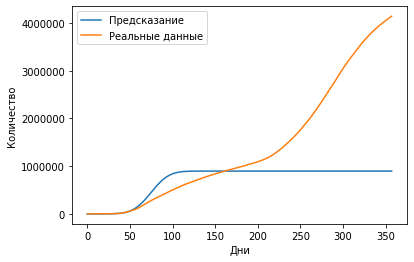

In [128]:
linereg=LinearRegression()
linereg.fit(train[['day', 'days_squared']], np.log(train.new_cases.values))
plt.plot(data_russia_may.day.values, np.cumsum(np.exp(linereg.predict(data_russia_may[['day', 'days_squared']]))), 
         label='Предсказание')
plt.plot(data_russia_may.day.values, data_russia_may.total_cases.values, label='Реальные данные')
plt.xlabel('Дни')
plt.ylabel('Количество')
plt.legend()

In [129]:
preds = linereg.predict(train[['day', 'days_squared']])
sigma_ = np.sqrt(np.sum((preds - np.log(train.new_cases.values)) ** 2) / len(train))

In [130]:
mu_ = np.array([0, 0, 0])
cur_sigma_ = np.array([[1000, 0, 0], [0, 1000, 0], [0, 0, 1000]])

In [131]:
def bayesian_update(mu, sigma, x, y, sigma_noise=sigma_):
    x_matrix = np.array([[1., x, x ** 2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [134]:
x_val, y_val = train.day.values, np.log(train.new_cases.values)

for i in range(len(train)):
    mu_, cur_sigma_ = bayesian_update(mu_, cur_sigma_, x_val[i], y_val[i])

print('Центр апостериорного распределения параметров: (%.4f, %.4f, %.4f)' % (mu_[0], mu_[1], mu_[2]))
print('Параметры линейной регрессии: (%.4f, %.4f, %.4f)' % (linereg.intercept_, *linereg.coef_))

Центр апостериорного распределения параметров: (-0.3966, 0.2756, -0.0018)
Параметры линейной регрессии: (-0.3966, 0.2756, -0.0018)


# 3c

In [135]:
def myplot_sample_lines(days, mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    last_day = []
    
    for i, w in enumerate(my_w):
        res[i,:] = w[0] + w[1] * xs + w[2] * xs**2
        plt.plot(days, np.cumsum(np.exp(w[0] + w[1] * days + w[2] * days**2)), 'k-', lw=.4)
        plt.xlabel('Дни')
        plt.ylabel('Количество заболевших')
        last_day.append(np.cumsum(np.exp(w[0] + w[1] * days + w[2] * days**2))[-1])
                           
    return res, np.array(last_day)

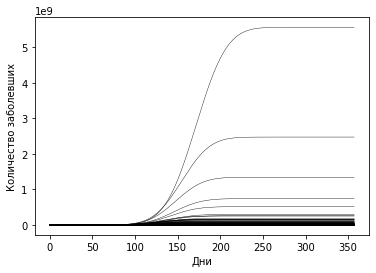

In [136]:
x, last_day = myplot_sample_lines(data_russia_may.day.values, mu_, cur_sigma_, np.arange(200), n=1500)

In [137]:
last_day = last_day[last_day < np.percentile(last_day, 99)]
print(f'Всего случаев коронавируса: {int(np.mean(last_day))}')
print(f'Количество заболевших при оптимистичном сценарии: {int(np.percentile(last_day, 10))}')
print(f'Количество заболевших при пессимистичном сценарии: {int(np.percentile(last_day, 90))}')

Всего случаев коронавируса: 2735417
Количество заболевших при оптимистичном сценарии: 329266
Количество заболевших при пессимистичном сценарии: 4550903


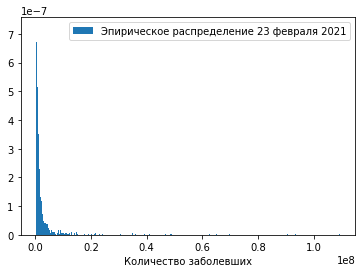

In [139]:
plt.hist(last_day, bins='auto', density=True, label='Эпирическое распределение 23 февраля 2021')
plt.xlabel('Количество заболевших')
plt.legend()
plt.show()